In [10]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [114]:
import os
import math
import json
import torch
import random
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

opj = lambda x, y: os.path.join(x, y)

In [21]:
data_path = Path('.')
ann_path = Path('/common/users/dm1487/YouCookII')
videos_path = data_path/'raw_frames/raw_videos'
steps_path = data_path/'raw_text'

In [22]:
v_train, v_val = videos_path/'training', videos_path/'validation'
t_train, t_val = steps_path/'training', steps_path/'validation'

print(v_train)

raw_frames/raw_videos/training


In [23]:
frame_features = torch.load(v_train/'101'/'S7hpTy1Rx1k.pth')
step_features = torch.load(t_train/'101'/'S7hpTy1Rx1k.pth')

In [69]:
labels = pd.read_csv(ann_path/'label_foodtype.csv', header=None, names=['class','class_label']).set_index('class')

In [8]:
label_counts = pd.DataFrame({'class': sorted(os.listdir(v_train)), 
              'counts': [len(os.listdir(opj(v_train, i))) for i in sorted(os.listdir(v_train))]})
label_counts['class'] = label_counts['class'].astype(np.int64)

<AxesSubplot:ylabel='Frequency'>

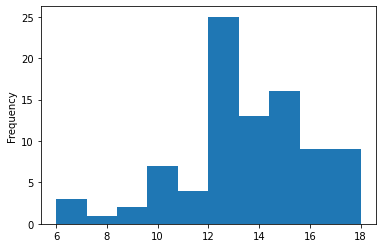

In [9]:
label_ = labels.join(label_counts.set_index('class')).reset_index()
label_ = label_.fillna(0)
label_ = label_[label_['counts'] > 5.0]
label_['counts'].plot.hist()

In [10]:
label_.head()

,class,class_label,counts
0,101,BLT,16.0
1,102,onion rings,16.0
2,103,burger,14.0
3,104,scrambled eggs,15.0
4,105,fried chicken,15.0


In [26]:
ann = []
with open(ann_path/'annotations/youcookii_annotations_trainval.json', 'rb') as f:
    ann = json.load(f)

In [12]:
annotations = pd.DataFrame([[k, v['recipe_type'], v['subset']] for k, v in ann['database'].items()], columns=['key', 'class', 'subset'])
annotations['class'] = annotations['class'].astype(np.int64)
annotations = annotations.set_index('class').join(label_.set_index('class')).reset_index()
training_ann = annotations[annotations['subset'] == 'training']
validation_ann = annotations[annotations['subset'] == 'validation']
training_ann['class_label'] = training_ann['class_label'].astype('category')
validation_ann['class_label'] = validation_ann['class_label'].astype('category')
training_ann.shape, validation_ann.shape

/tmp/ipykernel_336239/2903531243.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_ann['class_label'] = training_ann['class_label'].astype('category')
/tmp/ipykernel_336239/2903531243.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_ann['class_label'] = validation_ann['class_label'].astype('category')


((1333, 5), (457, 5))

<AxesSubplot:ylabel='Frequency'>

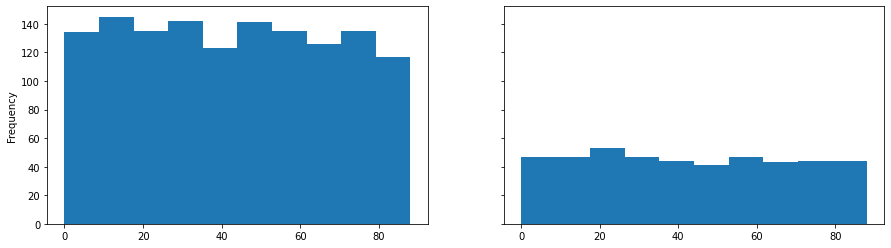

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
training_ann['class_label'].cat.codes.plot.hist(ax=ax[0])
validation_ann['class_label'].cat.codes.plot.hist(ax=ax[1])

In [14]:

training_ann['video_feat'] = training_ann[['class', 'key']].apply(lambda row: opj(v_train, f"{row['class']}/{row['key']}.pth"), axis=1)
training_ann = training_ann[training_ann['video_feat'].apply(lambda x: os.path.exists(x))]

training_ann['text_feat'] = training_ann[['class', 'key']].apply(lambda row: opj(t_train, f"{row['class']}/{row['key']}.pth"), axis=1)
training_ann = training_ann[training_ann['text_feat'].apply(lambda x: os.path.exists(x))]

training_outlier = '/common/users/dm1487/milnce_features/raw_frames/training/227/vUhoMXc7FJM.pth'
training_ann = training_ann[training_ann['video_feat'] != training_outlier]

validation_ann['video_feat'] = validation_ann[['class', 'key']].apply(lambda row: opj(v_val, f"{row['class']}/{row['key']}.pth"), axis=1)
validation_ann = validation_ann[validation_ann['video_feat'].apply(lambda x: os.path.exists(x))]
validation_ann['text_feat'] = validation_ann[['class', 'key']].apply(lambda row: opj(t_val, f"{row['class']}/{row['key']}.pth"), axis=1)
validation_ann = validation_ann[validation_ann['text_feat'].apply(lambda x: os.path.exists(x))]



training_ann.to_csv('training_with_labels_clip.csv')
validation_ann.to_csv('validation_with_labels_clip.csv')

/tmp/ipykernel_336239/614327944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_ann['video_feat'] = training_ann[['class', 'key']].apply(lambda row: opj(v_train, f"{row['class']}/{row['key']}.pth"), axis=1)
/tmp/ipykernel_336239/614327944.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_ann['video_feat'] = validation_ann[['class', 'key']].apply(lambda row: opj(v_val, f"{row['class']}/{row['key']}.pth"), axis=1)


In [15]:
training_ann = pd.read_csv('training_with_labels.csv')

In [16]:
BATCH_SIZE = 16
CLASS_LEVEL_BATCH = 8
VIDEO_LEVEL_BATCH = BATCH_SIZE // CLASS_LEVEL_BATCH
sampled_classes = random.sample(list(training_ann['class'].unique()), CLASS_LEVEL_BATCH)
training_ann[training_ann['class'].isin(sampled_classes)].groupby('class').apply(lambda x: x.sample(n=VIDEO_LEVEL_BATCH)).reset_index(drop = True).sample(frac=1)

,Unnamed: 0,Unnamed: 0.1,class,key,subset,class_label,counts,video_feat,text_feat,sizes
0,0,1,101,bQ3QYyFglc0,training,BLT,16.0,/common/users/dm1487/milnce_features/raw_frame...,/common/users/dm1487/milnce_features/raw_text/...,255
6,381,554,202,3cpjOPVkJ-Y,training,minestrone,10.0,/common/users/dm1487/milnce_features/raw_frame...,/common/users/dm1487/milnce_features/raw_text/...,206
13,941,1410,321,KgpkoZrOqck,training,general's chicken,12.0,/common/users/dm1487/milnce_features/raw_frame...,/common/users/dm1487/milnce_features/raw_text/...,555
9,595,885,219,Qy366zq9vws,training,sauerkraut,12.0,/common/users/dm1487/milnce_features/raw_frame...,/common/users/dm1487/milnce_features/raw_text/...,136
8,594,884,219,sJVn7H0pQRw,training,sauerkraut,12.0,/common/users/dm1487/milnce_features/raw_frame...,/common/users/dm1487/milnce_features/raw_text/...,240
11,737,1089,230,ztDPzIoZTj0,training,shish kabob,15.0,/common/users/dm1487/milnce_features/raw_frame...,/common/users/dm1487/milnce_features/raw_text/...,179
12,945,1416,321,Dr3rUEc1uVE,training,general's chicken,12.0,/common/users/dm1487/milnce_features/raw_frame...,/common/users/dm1487/milnce_features/raw_text/...,352
10,732,1081,230,IsyVAXuaCC8,training,shish kabob,15.0,/common/users/dm1487/milnce_features/raw_frame...,/common/users/dm1487/milnce_features/raw_text/...,554
5,320,468,124,OL_bDVVxmwA,training,hot dogs,15.0,/common/users/dm1487/milnce_features/raw_frame...,/common/users/dm1487/milnce_features/raw_text/...,547
2,94,133,107,8fVUcbC8MgM,training,calamari,17.0,/common/users/dm1487/milnce_features/raw_frame...,/common/users/dm1487/milnce_features/raw_text/...,301


In [17]:
from torch.utils.data import Dataset, DataLoader

class YCDataset(Dataset):
    
    def __init__(self, data_df, text_len=16, video_len=774):
        self.df = data_df
        self.text_len = text_len
        self.video_len = video_len

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        ## read step features
        
        step_feature = torch.load(self.df.iloc[idx]['text_feat']).to('cuda:1')
#         print(step_feature)
        true_step_len = step_feature.size(0) 
        assert step_feature.size(0) <= self.text_len, 'Increase text_len'
        padding = self.text_len - step_feature.size(0)
        step_feature = torch.vstack([step_feature, torch.zeros(padding, step_feature.size(1)).to('cuda:1')])
            
        
        ## read video features
        video_feature = torch.load(self.df.iloc[idx]['video_feat']).cpu()
#         print(video_feature)
        true_vid_len = video_feature.size(0)
        assert video_feature.size(0) <= self.video_len, f'Increase video_len {video_feature.size(0)}'
        padding = self.video_len - video_feature.size(0)
        video_feature = torch.vstack([video_feature, torch.zeros(padding, video_feature.size(1))])
        
        return {'step_len': true_step_len, 'video_len':true_vid_len, 'step_feature': step_feature.float(), 'video_feature': video_feature.float()}

In [18]:
dataset = YCDataset(training_ann)
# dl = DataLoader(dataset, batch_size=2)
# # print(next)
dataset[1]

{'step_len': 11,
 'video_len': 287,
 'step_feature': tensor([[ 5.5458, 16.0144, -2.8209,  ...,  0.4289, 12.4536,  2.2977],
         [11.9443, -6.3559, -1.6196,  ...,  0.4651,  9.2968,  4.3481],
         [ 1.7815, 25.4034,  5.7600,  ..., -7.6307,  2.6723, -2.3143],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
        device='cuda:1'),
 'video_feature': tensor([[-0.0084,  0.0197, -0.0209,  ..., -0.0073,  0.0013,  0.0073],
         [-0.0082,  0.0201, -0.0211,  ..., -0.0074,  0.0019,  0.0076],
         [-0.0069,  0.0193, -0.0206,  ..., -0.0081,  0.0022,  0.0072],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])}

In [88]:
dataset = YCDataset(training_ann)
dl = DataLoader(dataset, batch_size=1)
step_sizes = []
video_sizes = []
for d in tqdm(dl):
    step_feature, video_feature = d['step_feature'], d['video_feature']
    step_sizes.append(step_feature.size(1))
    video_sizes.append(video_feature.size(1))
print(max(step_sizes))
print(max(video_sizes))

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1193/1193 [00:32<00:00, 36.22it/s]

16
774


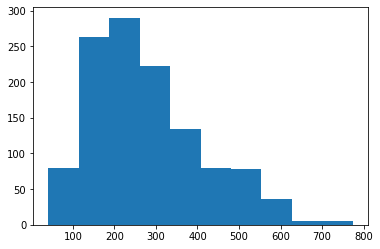

In [93]:
sizes = []
for idx, row in training_ann.iterrows():
    sizes.append(torch.load(row.loc['video_feat']).cpu().size(0))
plt.hist(sizes)
training_ann['sizes'] = sizes

In [94]:
training_ann[training_ann['sizes'] >= 800]['video_feat'].item()

ValueError: can only convert an array of size 1 to a Python scalar

In [331]:
class SampleBatchIdx:
    def __init__(self, dataset, cls_per_batch, batch_size):

        assert batch_size % cls_per_batch == 0, f'The batch size {batch_size} and classes per batch {cls_per_batch} are not compatible'
        self.dataset = dataset
        self.cls_per_batch = cls_per_batch
        self.batch_size = batch_size
        self.samples_per_cls = self.batch_size // self.cls_per_batch 

        
    def __len__(self):
        return int(round(len(self.dataset) / self.batch_size))
    
    def get_random_classes(self):
        return random.sample(list(self.dataset.df['class'].unique()), self.cls_per_batch)
    
    def __iter__(self):
        for _ in range(len(self)):
            sampled_classes = self.get_random_classes()
            batch_idxs = self.dataset.df[self.dataset.df['class'].isin(sampled_classes)].groupby('class').apply(lambda x: x.sample(n=self.samples_per_cls)).reset_index(drop = True).sample(frac=1).index
            yield batch_idxs.tolist()

In [332]:
batch_sampler = SampleBatchIdx(dataset, 8, 24)
dl = DataLoader(dataset, batch_sampler=batch_sampler)
# batch = next(iter(dl))
# batch['step_feature'].shape, batch['video_feature'].shape

In [333]:
for i in tqdm(dl):
    continue

100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


In [327]:
1194/24

49.75

In [97]:
sizes = []
for idx, row in validation_ann.iterrows():
    torch.save(torch.load(row['video_feat']).cpu(), row['video_feat'])

In [24]:
labels = pd.read_csv(ann_path/'label_foodtype.csv', header=None, names=['class','class_label']).set_index('class')

In [25]:
labels

,class_label
class,
101,BLT
102,onion rings
103,burger
104,scrambled eggs
105,fried chicken
...,...
421,samosa
422,wanton noodle
423,singapore curry laksa


In [57]:
s3dg_path = Path('/common/users/dm1487/youcook2_s3d_embeddings/s3d_features')
raw_text_path = Path('/common/users/dm1487/milnce_features/raw_text')

In [82]:
df_text = pd.DataFrame([[i, i.split('/')[-1].replace('.pth', '')] for i in glob.glob(str(raw_text_path/'*/*/*.pth'))], columns=['text_feat', 'key'])
df_text.head()

,text_feat,key
0,/common/users/dm1487/milnce_features/raw_text/...,Xp2HNiLabRI
1,/common/users/dm1487/milnce_features/raw_text/...,GyLX64aJY80
2,/common/users/dm1487/milnce_features/raw_text/...,RoLhMa9SHsI
3,/common/users/dm1487/milnce_features/raw_text/...,1uoT5TjyWsU
4,/common/users/dm1487/milnce_features/raw_text/...,qq0Wu8fJQLI


In [84]:
df_s3dg = pd.DataFrame([[i, i.split('/')[-1].replace('.npy', '')] for i in glob.glob(str(s3dg_path/'*.npy'))], columns=['video_feat', 'key'])
df_s3dg.head()

,video_feat,key
0,/common/users/dm1487/youcook2_s3d_embeddings/s...,YUWG15N2yW4
1,/common/users/dm1487/youcook2_s3d_embeddings/s...,3tGhLc48eX8
2,/common/users/dm1487/youcook2_s3d_embeddings/s...,PKt_za_XfF8
3,/common/users/dm1487/youcook2_s3d_embeddings/s...,irnNm5jRo1U
4,/common/users/dm1487/youcook2_s3d_embeddings/s...,C_6yMh3tEQk


In [89]:
df_all_s3dg = df_s3dg.set_index('key').join(df_text.set_index('key')).dropna()
df_all_s3dg = df_all_s3dg.join(annotations.set_index('key')).reset_index()

In [90]:
df_all_s3dg.head()

,key,video_feat,text_feat,class,subset,class_label,counts
0,YUWG15N2yW4,/common/users/dm1487/youcook2_s3d_embeddings/s...,/common/users/dm1487/milnce_features/raw_text/...,224,training,wiener schnitzel,12.0
1,3tGhLc48eX8,/common/users/dm1487/youcook2_s3d_embeddings/s...,/common/users/dm1487/milnce_features/raw_text/...,110,training,caesar salad,15.0
2,PKt_za_XfF8,/common/users/dm1487/youcook2_s3d_embeddings/s...,/common/users/dm1487/milnce_features/raw_text/...,120,training,hash browns,14.0
3,irnNm5jRo1U,/common/users/dm1487/youcook2_s3d_embeddings/s...,/common/users/dm1487/milnce_features/raw_text/...,313,training,salmon nigiri,9.0
4,C_6yMh3tEQk,/common/users/dm1487/youcook2_s3d_embeddings/s...,/common/users/dm1487/milnce_features/raw_text/...,403,training,pad thai,10.0


In [91]:
training_s3dg = df_all_s3dg[df_all_s3dg['subset'] == 'training']
validation_s3dg = df_all_s3dg[df_all_s3dg['subset'] == 'validation']

In [92]:
training_s3dg.to_csv('training_with_labels_s3dg.csv')
validation_s3dg.to_csv('validation_with_labels_s3dg.csv')

In [67]:
for idx, row in df_all_s3dg.iterrows():
    print(np.load(row['video_feat']).shape)
    if idx == 10:
        break

(100, 512)
(56, 512)
(54, 512)
(44, 512)
(132, 512)
(191, 512)
(36, 512)
(73, 512)
(62, 512)
(59, 512)
(77, 512)


## S3DG

In [5]:
# def create_data_s3dg():
#     ann = []
#     with open(ann_path/'annotations/youcookii_annotations_trainval.json', 'rb') as f:
#         ann = json.load(f)

#     labels = pd.read_csv(ann_path/'label_foodtype.csv', header=None, names=['class','class_label']).set_index('class')
#     label_counts = pd.DataFrame({'class': sorted(os.listdir(v_train)), 
#               'counts': [len(os.listdir(opj(v_train, i))) for i in sorted(os.listdir(v_train))]})
#     label_counts['class'] = label_counts['class'].astype(np.int64)

#     label_ = labels.join(label_counts.set_index('class')).reset_index()
#     label_ = label_.fillna(0)
#     label_ = label_[label_['counts'] > 5.0]

#     annotations = pd.DataFrame([[k, v['recipe_type'], v['subset']] for k, v in ann['database'].items()], columns=['key', 'class', 'subset'])
#     annotations['class'] = annotations['class'].astype(np.int64)
#     annotations = annotations.set_index('class').join(label_.set_index('class')).reset_index()

#     s3dg_path = Path('/common/users/dm1487/youcook2_s3d_embeddings/s3d_features')
#     raw_text_path = Path('/common/users/dm1487/milnce_features/raw_text')
#     df_text = pd.DataFrame([[i, i.split('/')[-1].replace('.pth', '')] for i in glob.glob(str(raw_text_path/'*/*/*.pth'))], columns=['text_feat', 'key'])
#     df_s3dg = pd.DataFrame([[i, i.split('/')[-1].replace('.npy', '')] for i in glob.glob(str(s3dg_path/'*.npy'))], columns=['video_feat', 'key'])
#     df_all_s3dg = df_s3dg.set_index('key').join(df_text.set_index('key')).dropna()
#     df_all_s3dg = df_all_s3dg.join(annotations.set_index('key')).reset_index()

#     size = []
#     for idx, row in df_all_s3dg.iterrows():
#         size.append(np.load(row['video_feat']).shape[0])
#     df_all_s3dg['frames_size'] = size
#     training_s3dg = df_all_s3dg[df_all_s3dg['subset'] == 'training']
#     validation_s3dg = df_all_s3dg[df_all_s3dg['subset'] == 'validation']
#     training_s3dg.to_csv('training_with_labels_s3dg.csv')
#     validation_s3dg.to_csv('validation_with_labels_s3dg.csv')
# create_data_s3dg()
import pandas as pd
import math
training_s3dg = pd.read_csv('training_with_labels_s3dg.csv')

In [6]:
training_s3dg_w_frames = training_s3dg.set_index('key').join(pd.read_csv('data/splits/train_duration_totalframe.csv').set_index('vid_id')).reset_index()
training_s3dg_w_frames['total/size'] = (training_s3dg_w_frames['total_frame']/training_s3dg_w_frames['frames_size'])
training_s3dg_w_frames['total/size'] = training_s3dg_w_frames['total/size'].apply(math.floor)
training_s3dg_w_frames['fps'] = (training_s3dg_w_frames['total_frame']/training_s3dg_w_frames['duration'])
training_s3dg_w_frames['fps'] = training_s3dg_w_frames['fps'].apply(math.ceil)
training_s3dg_w_frames['measure'] = training_s3dg_w_frames['total/size']/training_s3dg_w_frames['fps']

In [9]:
training_s3dg_w_frames.head()

,key,Unnamed: 0,video_feat,text_feat,class,subset,class_label,counts,frames_size,duration,total_frame,total/size,fps,measure
0,YUWG15N2yW4,0,/common/users/dm1487/youcook2_s3d_embeddings/s...,/common/users/dm1487/milnce_features/raw_text/...,224,training,wiener schnitzel,12.0,100,402.47,12060,120,30,4.00
1,3tGhLc48eX8,1,/common/users/dm1487/youcook2_s3d_embeddings/s...,/common/users/dm1487/milnce_features/raw_text/...,110,training,caesar salad,15.0,56,224.52,5388,96,24,4.00
2,PKt_za_XfF8,2,/common/users/dm1487/youcook2_s3d_embeddings/s...,/common/users/dm1487/milnce_features/raw_text/...,120,training,hash browns,14.0,54,219.66,5490,101,25,4.04
3,irnNm5jRo1U,3,/common/users/dm1487/youcook2_s3d_embeddings/s...,/common/users/dm1487/milnce_features/raw_text/...,313,training,salmon nigiri,9.0,44,176.73,4417,100,25,4.00
4,C_6yMh3tEQk,4,/common/users/dm1487/youcook2_s3d_embeddings/s...,/common/users/dm1487/milnce_features/raw_text/...,403,training,pad thai,10.0,132,529.53,15867,120,30,4.00


In [7]:
training_s3dg_w_frames['measure'].mean()

4.011714756544991

In [11]:
import pandas as pd
df = pd.read_csv('training_with_labels_s3dg.csv').groupby('class')['key'].count()
# df[df['']]
df[df == 5]

class
212    5
Name: key, dtype: int64

In [ ]:
os.listdir()